In [32]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [51]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_11542/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [52]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)

In [53]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       20000 non-null  int64  
 1   age                          20000 non-null  int64  
 2   sleep_duration               20000 non-null  float64
 3   sleep_quality                20000 non-null  int64  
 4   stress_level                 20000 non-null  int64  
 5   blood_pressure               20000 non-null  int64  
 6   heart_rate                   20000 non-null  int64  
 7   daily_steps                  20000 non-null  int64  
 8   physical_activity            20000 non-null  int64  
 9   height                       20000 non-null  int64  
 10  weight                       20000 non-null  int64  
 11  sleep_disorder               20000 non-null  int64  
 12  wake_up_during_night         20000 non-null  int64  
 13  feel_sleepy_duri

In [55]:
omit_cols = ['blood_pressure']
df = df.drop(columns=omit_cols)

In [56]:
#Select the target columns
target_cols = ['dry_eye_disease'] 
y = df[target_cols]

#Drop the target columns, so the rest are feature columns
X = df.drop(columns=target_cols)


In [58]:
from sklearn.model_selection import train_test_split
# Splitting into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import shap
# Define XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [61]:
# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END 

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [62]:
# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [63]:
# Train final model with best parameters
best_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [64]:
# Evaluate on test set
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Test MSE: 0.20960885286331177


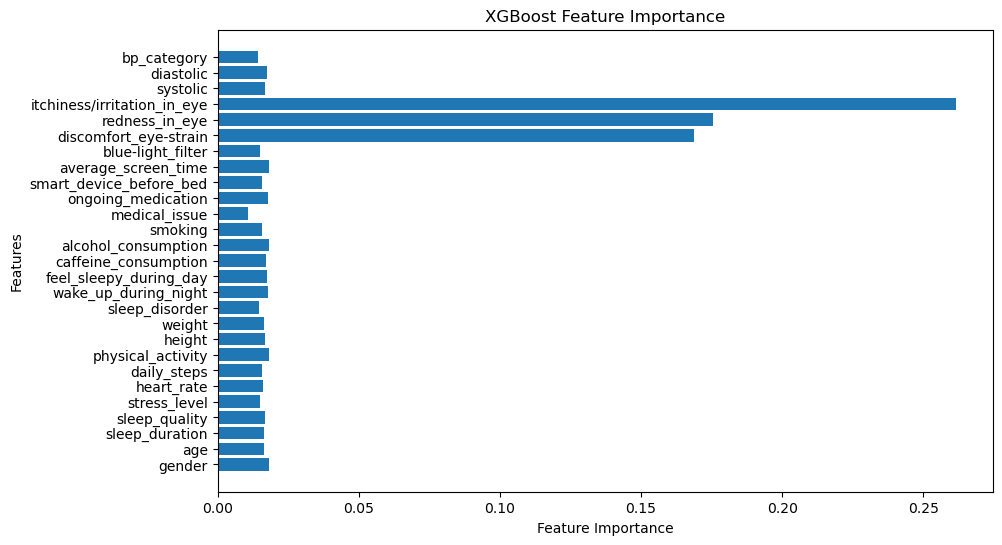

In [67]:
# Feature Importance
feature_names = X.columns.tolist()
importance = best_xgb.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

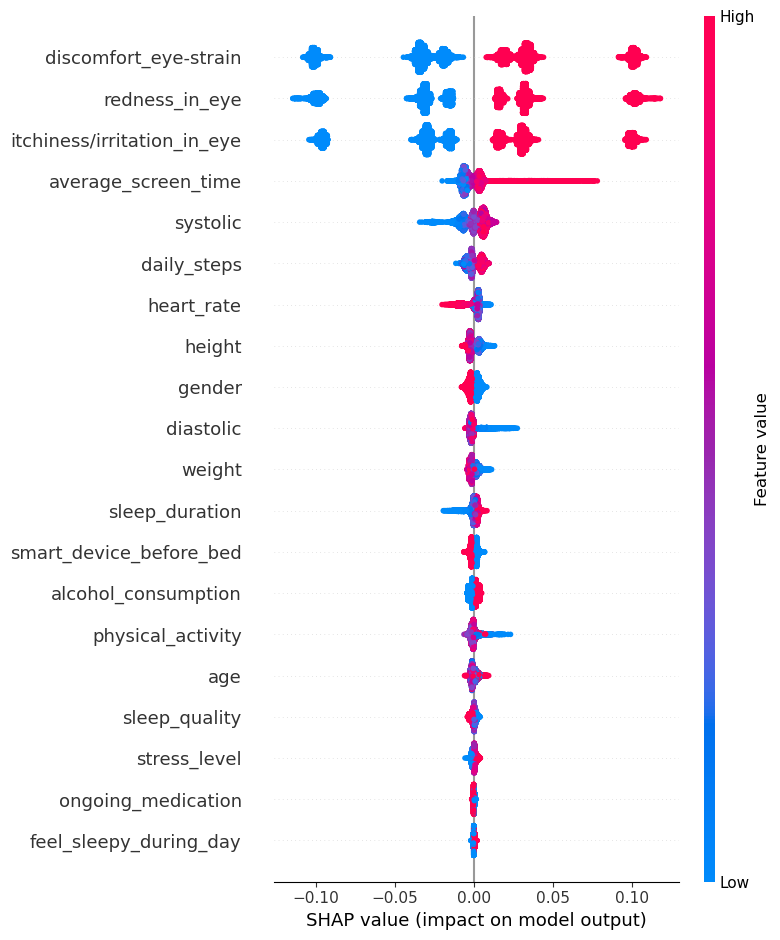

In [68]:
# SHAP values for feature selection
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feature_names)
